# Inference Code

2021.12.08 (Wed)
201912306 Jinsu Ha

In [1]:
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import os

use_gpu = torch.cuda.torch.cuda.is_available()


## DataLoader

In [2]:
from torchvision import transforms

class Place365DataLoader(Dataset): 
    def __init__(self, data_dir, split="train"):
        self.root = data_dir  
        self.split = split
        self.files = {}

        self.images_base = os.path.join(self.root, self.split)
        # self.annotations_base = os.path.join(self.root, self.split, 'rgb')
        self.annotations_base = self.images_base # Same directory, Loading method is different only
        self.files[split] = self.recursive_glob(rootdir=self.images_base, suffix='.jpg')

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        print("Found %d %s images" % (len(self.files[split]), split))

    # def ToTensor(self, sample):
    #     # swap color axis because
    #     # numpy image: H x W x C
    #     # torch image: C X H X W
    #     img = sample['gray']
    #     mask = sample['rgb']
    #     img = np.array(img).astype(np.float32).transpose((2, 0, 1))
    #     mask = np.array(mask).astype(np.float32)

    #     img = torch.from_numpy(img).float()
    #     mask = torch.from_numpy(mask).float()

    #     return {'gray': img,
    #             'rgb': mask}

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, idx): 
        img_path = self.files[self.split][idx].rstrip()
        lbl_path = self.files[self.split][idx].rstrip()
        
        _img = Image.open(img_path).convert('L')
        _target = Image.open(lbl_path).convert('RGB')


        sample = {'gray': _img, 'rgb': _target}

        tr_train_input = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            # transforms.RandomResizedCrop(),
            transforms.ToTensor()])
            # transforms.Normalize(mean=(0.485), std=(0.229))])        
        tr_train_gt = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])
            # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

        # W/ Normalization
        # tr_val_input = transforms.Compose([
        #     # transforms.RandomHorizontalFlip(),yy
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=(0.485), std=(0.229))])        
        # tr_val_gt = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])  
        
        # W/O Norm          
        tr_val_input = transforms.Compose([
            # transforms.RandomHorizontalFlip(),yy
            transforms.ToTensor()])        
        tr_val_gt = transforms.Compose([
            transforms.ToTensor()])    

        tr_test_input = transforms.Compose([
            # transforms.RandomHorizontalFlip(),yy
            transforms.ToTensor()])        
        tr_test_gt = transforms.Compose([
            transforms.ToTensor()])    
            
        composed_transforms_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])    

        if self.split == 'train':
            return tr_train_input(sample['gray']), tr_train_gt(sample['rgb'])
        elif self.split == 'val':
            return tr_val_input(sample['gray']), tr_val_gt(sample['rgb'])

        elif self.split == 'test':
            return tr_test_input(sample['gray']), tr_test_gt(sample['rgb'])


    def recursive_glob(self, rootdir='.', suffix=''):
        """Performs recursive glob with given suffix and rootdir
            :param rootdir is the root directory
            :param suffix is the suffix to be searched
        """
        return [os.path.join(looproot, filename)
                for looproot, _, filenames in os.walk(rootdir)
                for filename in filenames if filename.endswith(suffix)]

## Model Definition

### [Net_1] Resnet18 based model

In [63]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class Net_1(nn.Module):
  def __init__(self):
    super(Net_1, self).__init__()

    # Using ResNet 0~6 Layers
    resnet = models.resnet18() 
    
    # Replace input layer to grayscale input
    self.resnet_part = nn.Sequential(nn.Conv2d(1, 3, kernel_size=3, padding=1),
                                        *list(resnet.children())[0:6]
                                        )

    ## Upsample (Encode) ResNet output feature map
    self.upsample = nn.Sequential(     
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),

      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
      
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
      nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),
      
      nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(8),
      nn.ReLU(),
      nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1),
    )

  def forward(self, input):
    # Encoder
    resnet_part_output = self.resnet_part(input)
    # Decoder(upasampling)
    output = self.upsample(resnet_part_output)
    return output

### [Net_2] Unet based Model

In [3]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
# input: 256 x 256 x 1
# output: 256 x 256 x 3
# Torch: C x H x W

# U_net based model (w/o concatenate)
class Net_2(nn.Module):
  def __init__(self):
    super(Net_2, self).__init__()
    
    self.Down = nn.Sequential(

      nn.Conv2d(1, 4, kernel_size=3, padding=1),
      nn.BatchNorm2d(4),
      nn.ReLU(inplace=True),

      nn.Conv2d(4, 16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),

      nn.Conv2d(16, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),

      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      
      nn.Conv2d(256, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2)
      # Feature map size: 512x32x32 (CxHxW)

    )

    self.Up = nn.Sequential(
      #512x32x32
      nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
      nn.Conv2d(512, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),

      nn.Conv2d(256, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
       
      # 128x64x64
      nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
      nn.Conv2d(128, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),

      nn.Conv2d(64, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),

      # 32x128x128
      nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
      nn.Conv2d(32, 16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),

      nn.Conv2d(16, 8, kernel_size=3, padding=1),
      nn.BatchNorm2d(8),
      nn.ReLU(inplace=True),
      # 16x256x256

      nn.Conv2d(8, 3, kernel_size=3, padding=1),
      nn.BatchNorm2d(3),
      nn.ReLU(inplace=True)
      # 3x256x256
    )

  def forward(self, input):
    # Convolution
    output = self.Down(input)

    # Upsample using ConvTranspose2d
    output = self.Up(output)
    return output

### [Net_3] Resnet152 based model

In [5]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
# input: 256 x 256 x 1
# output: 256 x 256 x 3
# Torch: C x H x W

# Resnet152 based model
class Net_3_sub(nn.Module):
  """([UpConv] => [Conv] => BN => ReLU => [Conv] => BN => ReLU) """
  def __init__(self, in_channels):
    super().__init__()
      # super(Net_3_sub, self).__init__(in_channels=in_channels)
      # quater channel, double feature map
    self.Up = nn.Sequential(
        nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
        nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1),
        nn.BatchNorm2d(in_channels//2),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1),
        nn.BatchNorm2d(in_channels//2),
        nn.ReLU(inplace=True)
    )


  def forward(self, x):
    return self.Up(x)


class Net_3(nn.Module):
  def __init__(self):
    super(Net_3, self).__init__()
    
    # Using ResNet pretrained model
    self.resnet_src = models.resnet152(pretrained=False)
    
    # Remove FC(output) layer from resnet
    self.resnet_wo_fc = torch.nn.Sequential(
      nn.Conv2d(1, 3, kernel_size=3, padding=1),
      *(list(self.resnet_src.children())[:-1])
      )

    # Upsampling using ConvTranspose2d
    in_channels = 2048
    self.up1 = Net_3_sub(in_channels)
    self.up2 = Net_3_sub(in_channels//2)
    self.up3 = Net_3_sub(in_channels//4)
    self.up4 = Net_3_sub(in_channels//8)
    self.up5 = Net_3_sub(in_channels//16)
    self.up6 = Net_3_sub(in_channels//32)
    self.up7 = Net_3_sub(in_channels//64)
    self.up8 = Net_3_sub(in_channels//128)
    
    # output conv
    self.out = nn.Conv2d(8, 3, kernel_size=3, padding=1)

  def forward(self, input):
    x = self.resnet_wo_fc(input)
    x = self.up1(x)
    x = self.up2(x)
    x = self.up3(x)
    x = self.up4(x)
    x = self.up5(x)
    x = self.up6(x)
    x = self.up7(x)
    x = self.up8(x)
    x = self.out(x)
    return x

### [Net_4] ECCV16 (From https://github.com/richzhang/colorization/)

In [6]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
# input: 256 x 256 x 1
# output: 256 x 256 x 3
# Torch: C x H x W

class Net_4(nn.Module):
  def __init__(self):
    super(Net_4, self).__init__()
    self.model1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(64)                      
                          )

    self.model2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(128)                      
                          )

    self.model3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(256)                      
                          )

    self.model4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(512)                      
                          )

    self.model5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(512)                      
                          )

    self.model6 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(512)                      
                          )

    self.model7 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.BatchNorm2d(512)                      
                          )

    self.model8 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                          nn.ReLU(True),
                          nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True)                  
    )

    self.softmax = nn.Softmax(dim=1)
    self.model_out = nn.Conv2d(313, 3, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
    self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear') 
    # self.upsample4 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2) Upsample 대신 이거?

    

  def forward(self, input_l):
    conv1_2 = self.model1(input_l)
    conv2_2 = self.model2(conv1_2)
    conv3_3 = self.model3(conv2_2)
    conv4_3 = self.model4(conv3_3)
    conv5_3 = self.model5(conv4_3)
    conv6_3 = self.model6(conv5_3)
    conv7_3 = self.model7(conv6_3)
    conv8_3 = self.model8(conv7_3)
    out_reg = self.model_out(self.softmax(conv8_3))

    return self.upsample4(out_reg)

In [7]:
# # Testing Model !!
# model_test = Net_4()
# print(model_test)
# model_test.cuda()
# infer = model_test(gray.unsqueeze(0))
# infer.shape


## Utils

### 1. Save Model

In [4]:
from datetime import datetime

def save_model(save_dir, epoch):
    model_save_dir = save_dir
    # "/home/ailab/jinsu/pytorch_study/pytorch-template/imageColorization/model_saved/unet_wo_concat"
    # nb_epochs = 2656
    # batch_size = 128
    now = datetime.now()
    
    filename = str(now)+"_epoch"+ str(epoch)+'.pth.tar'
    model_save_path = os.path.join(model_save_dir, filename)
    torch.save(model.state_dict(), model_save_path)
    print("Model saved to " + str(model_save_path))

### 2. Validation

In [5]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metric
def pnsr(img1, img2):
    mse = torch.mean((img1-img2)**2)
    return 20 * torch.log10(255.0/torch.sqrt(mse)) 

# Validation Code
def validation(model_val, dataloader):
    model = model_val
    model.eval()
    
    dataloader_val = dataloader  # DataLoader(dataset_val, batch_size=1, shuffle=True)
    with torch.no_grad():
        scores = 0
        for batch_idx, samples in enumerate(dataloader_val):
            gray, rgb = samples

            # dataloader_val.sampler
            # for batch_idx, samples in dataloader:
            #     gray, rgb = samples
            # sample = dataset_val[np.random.randint(100)]
            if use_gpu: gray, rgb = gray.cuda(), rgb.cuda()
            prediction = model(gray)
            score = pnsr(rgb, prediction.squeeze())
            # print(batch_idx, score)
            scores = scores + score

        print("Total pnsr value: "+str(scores.item()) + " Avg pnsr value: " + str(scores.item()/dataloader_val.__len__()))
            # 10epoch 5960
            # 20epoch 6630
            # 200epoch 6856
            # 400epoch 6831

### 3. Load Model

In [6]:
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_load, model_path):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # ResNet18
    # model_load = net
    # model_parameter = ""
    # model_load.load_state_dict(torch.load(os.path.join('model_saved/resnet18_v2.0/', model_parameter)))

    # U-Net
    # model_load = net
    # model_parameter = ""
    # model_load.load_state_dict(torch.load(os.path.join('model_saved/unet_wo_concat/', model_parameter)))

    # ResNet152
    # model_load = net
    # model_parameter = ""
    # model_load.load_state_dict(torch.load(os.path.join('model_saved/resnet152/', model_parameter)))

    # ECCV16
    # model_load = net
    # model_parameter = "2021-12-08 02:47:59.914963_epoch600.pth.tar"
    # model_load.load_state_dict(torch.load(os.path.join('model_saved/eccv/', model_parameter)))


    # model_load = net
    # model_dir = model_path
    model_load.load_state_dict(torch.load(os.path.join('model_saved/', model_path)))
    model_load.eval()
    model_load.to(device)
    return model_load

### 4. Inference

In [110]:
# 함수화 할 것!

def inference(model_load, split = 'val'):
    savemodel = model_load
    use_gpu = torch.cuda.torch.cuda.is_available()

    dataset_val = Place365DataLoader(data_dir='place365', split=split)
    dataloader_val = DataLoader(dataset_val, shuffle=True)
    with torch.no_grad():
        sample = dataset_val[np.random.randint(dataset_val.__len__())]
        gray, rgb = sample
        if use_gpu: gray, rgb = gray.cuda(), rgb.cuda()
        prediction = savemodel(gray.unsqueeze(0))
        # print(prediction.shape)

    # Visualize Output!
    plt.figure(figsize=(30, 10))
    plt.subplot(1,3,1)
    plt.imshow(to_pil_image(gray), cmap='gray')
    plt.title('input image')
    plt.subplot(1,3,2)
    plt.imshow(to_pil_image(rgb))
    plt.title('gt')
    plt.subplot(1,3,3)
    plt.imshow(to_pil_image(prediction.squeeze()))
    plt.title('prediction')        
    print(prediction.shape)
    validation(model_load, dataloader_val)
    return prediction
        

## Train

### 1. Hyperparameter

In [42]:
# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.torch.cuda.is_available()

# Hyperparams
batch_size = 32
lr = 1e-2
nb_epochs = 500

# Load training dataloader
dataset = Place365DataLoader(data_dir = "place365/jieun", split='train')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load validation dataloader
batch_size_val = 1
dataset_val = Place365DataLoader(data_dir = "place365/jieun", split='val')
dataloader_val = DataLoader(dataset_val, batch_size=batch_size_val, shuffle=False)

# Load model
# model = Net_1().cuda() # ResNet18
model = Net_2().cuda() # Unet
# model = Net_3().cuda() # Resnet152
# model = Net_4().cuda() # ECCV16 paper
model.train() # Set to train mode

# Set Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)

Found 4096 train images
Found 1024 val images


### 2. Training

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(nb_epochs + 1)):
  costs=0
  for batch_idx, samples in enumerate(dataloader):


    gray, rgb = samples
    if use_gpu: gray, rgb = gray.cuda(), rgb.cuda()

    # Propagation
    prediction = model(gray)

    # Calc cost
    cost = F.mse_loss(prediction, rgb)
    # cost = F.kl_div(prediction.log(), rgb, reduction='batchmean')

    # Gradient Descent
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs = costs+cost.item()

  # print cost every epoch
  print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        costs
        ))

  # print score every epoch
  validation(model, dataloader_val)
  
  # Save model parameter every 100 epoch
  if epoch%10 == 0:
    save_model('model_saved/jieun_dataset/unet', epoch)
    # save_model('model_saved/kl_loss_test', epoch)
    # save_model('model_saved/test', epoch)
    # save_model('model_saved/resnet18', epoch)
    # save_model('model_saved/resnet152', epoch)
    # save_model('model_saved/resnet', epoch)



## Result

Found 300 train images
torch.Size([1, 3, 256, 256])
Total pnsr value: 19383.740234375 Avg pnsr value: 64.61246744791667


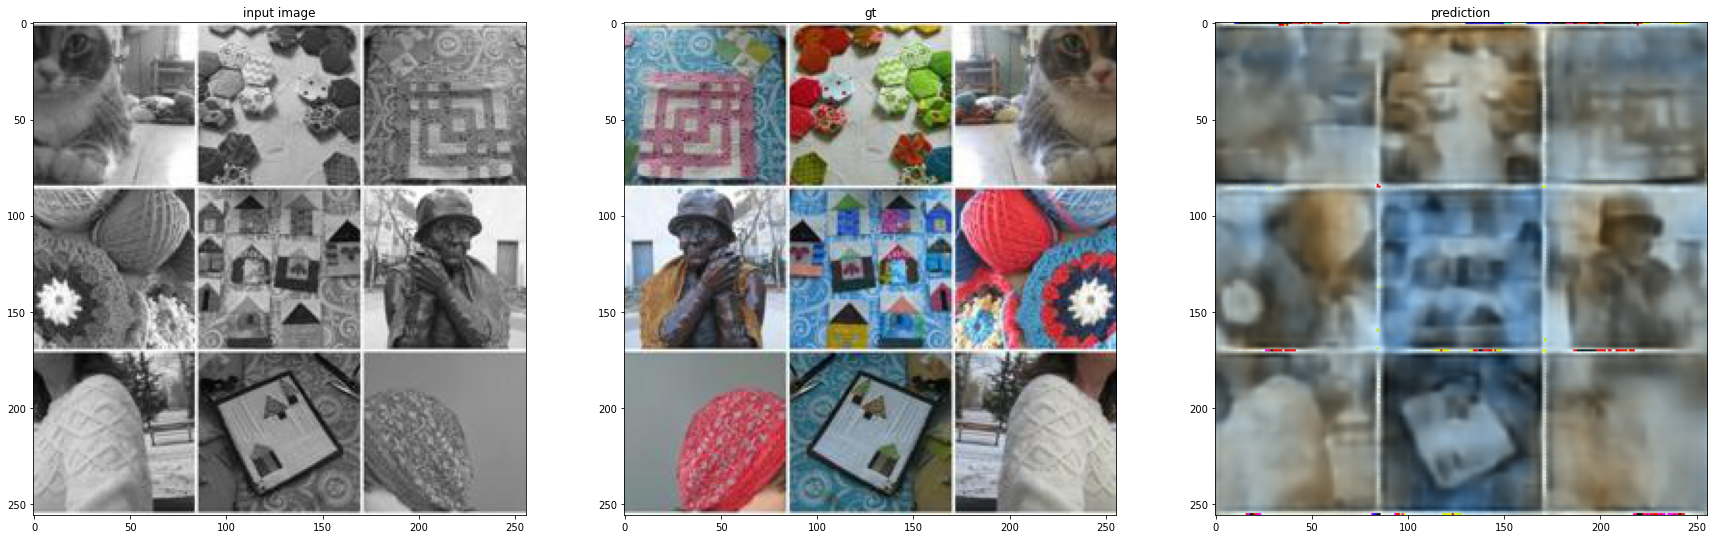

In [67]:
net = Net_1()
# net = Net_4()
model_loaded = load_model(net, "resnet18_v2.0/2021-12-07 11:11:59.455343_epoch2000.pth.tar")
inference(model_loaded, "train")

Found 300 train images
torch.Size([1, 3, 256, 256])
Total pnsr value: 19466.615234375 Avg pnsr value: 64.88871744791666


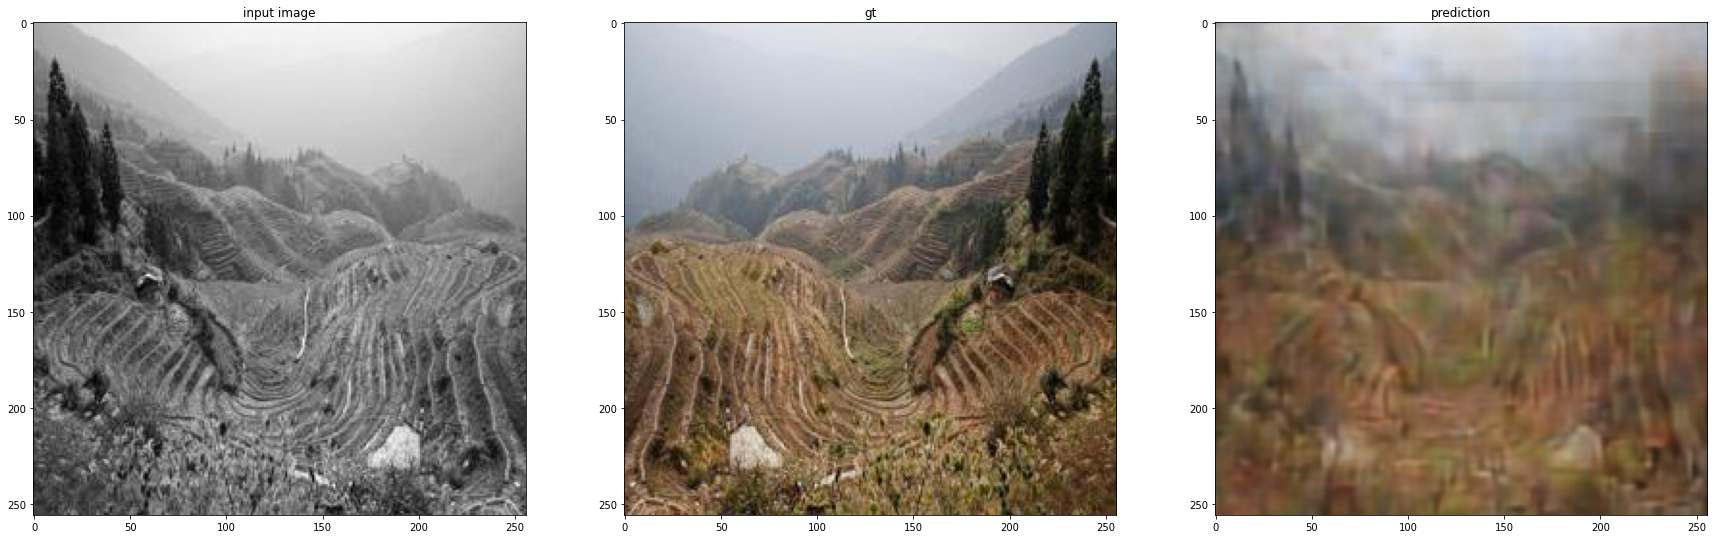

In [92]:
net = Net_2()
# net = Net_4()
model_loaded = load_model(net, "unet_wo_concat/2021-12-07 21:15:48.544985_epoch5000.pth.tar")
inference(model_loaded, "train")

## Save Inference Result

Found 300 train images
torch.Size([1, 3, 256, 256])
Total pnsr value: 19132.6953125 Avg pnsr value: 63.77565104166667


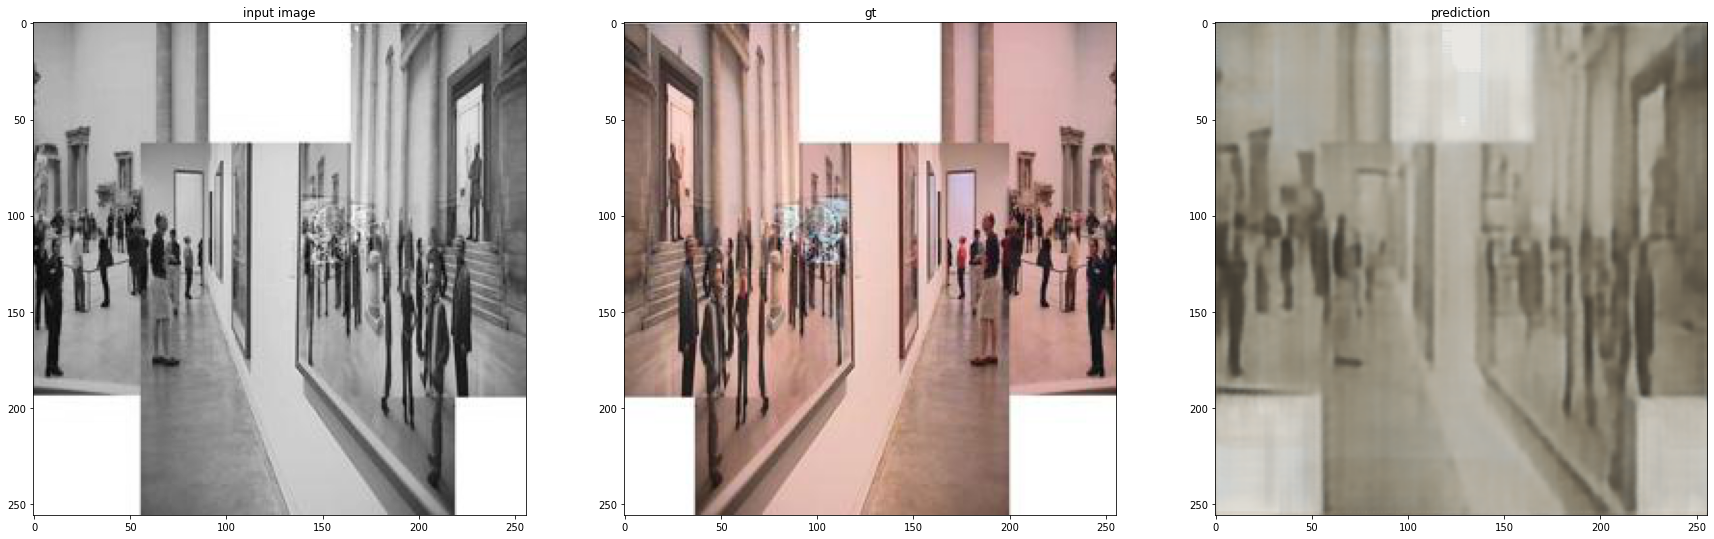

In [111]:
net = Net_2()
# path = 'unet_wo_concat/2021-12-07 21:15:48.544985_epoch5000.pth.tar'
path = 'jieun_dataset/unet/2021-12-08 05:08:06.393611_epoch110.pth.tar' # jieun dataset
model_loaded = load_model(net, path)

pred = inference(model_loaded, split='train')


In [193]:
def save_result(net, savemodel, save_path, split='test'):
    
    use_gpu = torch.cuda.torch.cuda.is_available()

    dataset = Place365DataLoader(data_dir='place365', split=split)
    dataloader = DataLoader(dataset, shuffle=True)
    with torch.no_grad():
        for batch_idx, samples in enumerate(dataloader):
            gray, rgb = samples
            if use_gpu: gray, rgb = gray.cuda(), rgb.cuda()
            prediction = savemodel(gray)

            # Save Torch Tensor
            save_path_ = os.path.join(save_path, str(batch_idx+1)+".png")
            plt.imshow(to_pil_image(prediction.squeeze()))
            torchvision.utils.save_image( prediction, save_path_ )
        print(str(dataloader.__len__())+ " Image Saved")

    validation(savemodel, dataloader)
        

In [194]:
# plt.imsave("/home/ailab/jinsu/imageColorization/place365/a.png", to_pil_image(pred.squeeze()))

Found 10 test images
10 Image Saved
Total pnsr value: 653.2119750976562 Avg pnsr value: 65.32119750976562


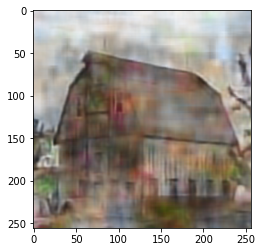

In [195]:
net = Net_2()
path = 'unet_wo_concat/2021-12-07 21:15:48.544985_epoch5000.pth.tar'
# path = 'unet/2021-12-08 05:08:06.393611_epoch110.pth.tar' # jieun dataset
model_loaded = load_model(net, path)
save_result(net, model_loaded, "/home/ailab/jinsu/imageColorization/place365/inference_result", 'test' )

## Model Figure

In [48]:
import torch
import torchvision # model을 불러오기 위해 import 하였습니다.
import torch.onnx

# 1. 임의의 model을 사용해도 되며, 실제 사용하는 custom model을 불러와서 저장해 보시기 바랍니다.
model = model_loaded

# 2. model의 파라미터를 OrderedDict 형태로 저장합니다.
params = model.state_dict()

# 3. 동적 그래프 형태의 pytorch model을 위하여 data를 model로 흘려주기 위한 더미 데이터 입니다.
dummy_data = torch.empty(1, 1, 256, 256, dtype = torch.float32).cuda()

# 4. onnx 파일을 export 해줍니다. 함수에는 차례대로 model, data, 저장할 파일명 순서대로 들어가면 됩니다.
torch.onnx.export(model, dummy_data, "/home/ailab/jinsu/imageColorization/unet_wo_concat.onnx")
from torchinfo import summary
summary(model, (1, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Net_2                                    --                        --
├─Sequential: 1-1                        [1, 512, 32, 32]          --
│    └─Conv2d: 2-1                       [1, 4, 256, 256]          40
│    └─BatchNorm2d: 2-2                  [1, 4, 256, 256]          8
│    └─ReLU: 2-3                         [1, 4, 256, 256]          --
│    └─Conv2d: 2-4                       [1, 16, 256, 256]         592
│    └─BatchNorm2d: 2-5                  [1, 16, 256, 256]         32
│    └─ReLU: 2-6                         [1, 16, 256, 256]         --
│    └─Conv2d: 2-7                       [1, 32, 256, 256]         4,640
│    └─BatchNorm2d: 2-8                  [1, 32, 256, 256]         64
│    └─ReLU: 2-9                         [1, 32, 256, 256]         --
│    └─MaxPool2d: 2-10                   [1, 32, 128, 128]         --
│    └─Conv2d: 2-11                      [1, 64, 128, 128]         18,496
│    └─B

### 성능이 너무 안나와서, COLORSPACE 변경하는 방법으로 재학습 해야 할 듯..
### 그리고 edge 뭉개지는 현상도 해결해야 함!!